In [176]:
import os 
import gc 
import numpy as np 
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
import lightgbm as lgb
import shap
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
from sksurv.util import Surv
from pathlib import Path
import logging
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Define path
DATA_DIR = PROJECT_ROOT / "data" / "processed"

LOAD THE DATA

In [177]:
EVENTS_PROPS_FILE = DATA_DIR / "events_with_properties.csv"
ITEM_PROPS_FILE = DATA_DIR / "item_properties.csv" 
USER_FEATS_FILE = DATA_DIR / "users_pipeline.csv"

In [178]:
def load(path):
    logging.info("Loading from %s", path)
    df = pd.read_csv(path)
    if 'timestamp'in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    if 'first_event'in df.columns:
        df['first_event'] = pd.to_datetime(df['first_event'])
    if 'last_event'in df.columns:
        df['last_event'] = pd.to_datetime(df['last_event'])
    return df
events = load(EVENTS_PROPS_FILE)
item_props = load(ITEM_PROPS_FILE)
user_feats = load(USER_FEATS_FILE)

BUILD THE TIME_TO_EVENT AND CHURNED LABEL FOR CHURN PREDICTION AND SURVIVAL ANALYSIS

In [179]:
churn_window_days = 50
churn_window = pd.Timedelta(days=churn_window_days)

events_sorted = events.sort_values(['visitorid','timestamp']).reset_index(drop=True)
data_start = events_sorted['timestamp'].min()
data_end = events_sorted['timestamp'].max()
print("data range:", data_start, "to", data_end)

data range: 2015-05-03 03:00:04.384000 to 2015-09-18 02:59:47.788000


In [180]:
def compute_time_to_churn(
    df_tx,
    churn_window_days: int,
    data_end: pd.Timestamp
):
    churn_window = pd.Timedelta(days=churn_window_days)
    results = []
    df_tx = df_tx.sort_values(['visitorid', 'timestamp'])
    for vid, grp in df_tx.groupby('visitorid'):
        times = grp['timestamp']
        first_tx = times.iloc[0]
        last_tx  = times.iloc[-1]
        inactivity = data_end - last_tx
        if inactivity >= churn_window:
            churned = 1
            churn_time = last_tx 
        else:
            churned = 0
            churn_time = data_end

        time_to_event = (churn_time - first_tx).total_seconds() / (3600 * 24)

        results.append({
            'visitorid': vid,
            'origin': first_tx,
            'time_to_event': time_to_event,
            'churned': churned
        })

    return pd.DataFrame(results)


In [181]:
tx = events_sorted[events_sorted['event'] == 'transaction']
user_churn = compute_time_to_churn(tx, churn_window_days,data_end)
user_churn.head()


,visitorid,origin,time_to_event,churned
0,172,2015-08-15 01:29:01.230,34.063039,0
1,186,2015-08-12 16:34:57.040,36.433921,0
2,264,2015-09-07 17:34:45.614,10.392386,0
3,419,2015-07-29 05:03:12.695,0.000000,1
4,539,2015-06-16 05:39:38.673,0.000000,1


In [182]:
user_data = user_feats.merge(user_churn, on='visitorid', how='left')

In [183]:
user_data = user_data.drop(columns= ['view_price', 'addtocart_price', 'tx_price','avg_inter_event_days'])

#### CHURN PREDICTION

In [184]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    user_data,
    test_size=0.2,
    stratify=user_data['churned'],
    random_state=42
)

print(train_df['churned'].value_counts(normalize=True))
print(test_df['churned'].value_counts(normalize=True))

churned
1    0.657767
0    0.342233
Name: proportion, dtype: float64
churned
1    0.657005
0    0.342995
Name: proportion, dtype: float64


In [185]:
# choose features (drop identifiers & time columns)
drop_cols = ['visitorid','origin','last_event','first_event','time_to_event','churned','Unnamed: 0','business_label', 'last_purchase', 'recency_days']
features = [c for c in user_data.columns if c not in drop_cols]

X_train = train_df[features]
y_train = train_df['churned'].astype(int)
X_test = test_df[features]
y_test = test_df['churned'].astype(int)

# LightGBM dataset
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 30,
    'seed': 42,
    'verbosity': -1
}
bst = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train,lgb_valid])
# predict
y_pred_proba = bst.predict(X_test, num_iteration=bst.best_iteration)
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


ROC AUC: 0.9225352112676056


In [186]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert y_test into numpy array
y_true = np.array(y_test.to_list())
y_pred = y_pred_proba

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)

MSE : 0.08319550605327837
RMSE: 0.28843631195339875
MAE : 0.09875735496947798


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\Acer\AppData\Local\Temp\ipykernel_10424\1224396660.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_test, show=True)


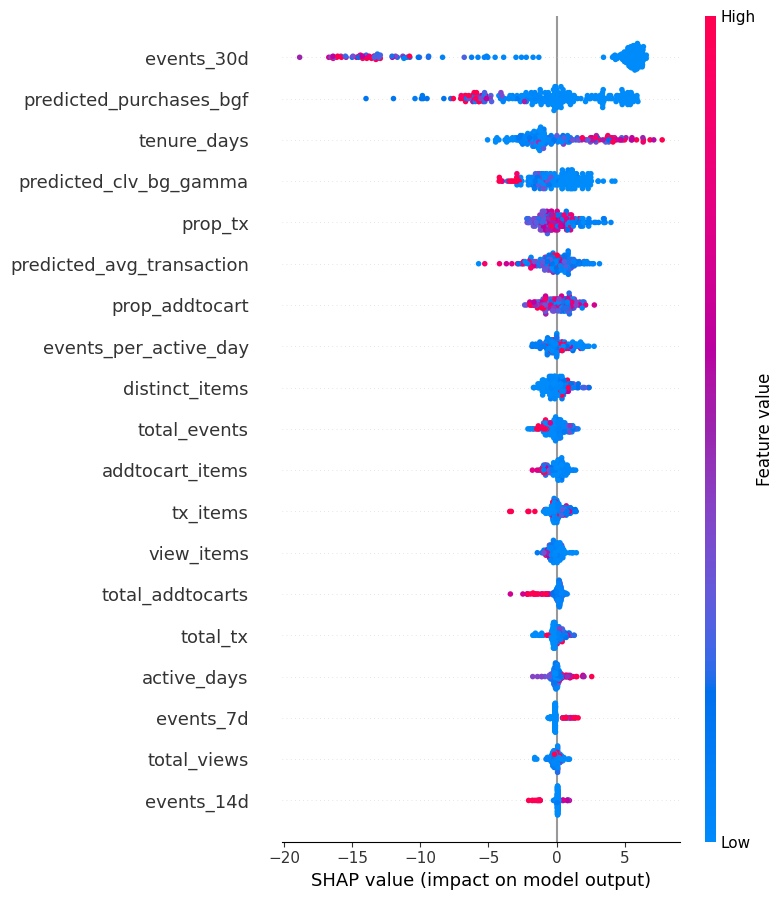

                      feature  shap_mean_abs
0                  events_30d       7.626278
1     predicted_purchases_bgf       3.279442
2                 tenure_days       2.140532
3      predicted_clv_bg_gamma       1.390420
4                     prop_tx       1.003080
5   predicted_avg_transaction       0.979220
6              prop_addtocart       0.805843
7       events_per_active_day       0.680146
8              distinct_items       0.590724
9                total_events       0.529590
10            addtocart_items       0.444868
11                   tx_items       0.424090
12                 view_items       0.348348
13           total_addtocarts       0.345070
14                   total_tx       0.333765
15                active_days       0.290960
16                  events_7d       0.253130
17                total_views       0.235186
18                 events_14d       0.197480


In [187]:

explainer = shap.TreeExplainer(bst)
shap_vals = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(shap_vals, X_test, show=True)
# top features
importance = pd.DataFrame({'feature':X_test.columns, 'shap_mean_abs':np.abs(shap_vals).mean(axis=0)})
importance = importance.sort_values('shap_mean_abs', ascending=False).reset_index(drop=True)
print(importance.head(20))



### SURVIVAL ANALYSIS

In [188]:

surv_train = train_df.copy()
surv_train['duration'] = surv_train['time_to_event']
surv_train['event'] = surv_train['churned']


surv_test = test_df.copy()
surv_test['duration'] = surv_test['time_to_event']
surv_test['event'] = surv_test['churned']


surv_features = features.copy()


scaler = StandardScaler()

surv_train[surv_features] = scaler.fit_transform(
    surv_train[surv_features].fillna(0)
)

surv_test[surv_features] = scaler.transform(
    surv_test[surv_features].fillna(0)
)


#### Kaplan Meier

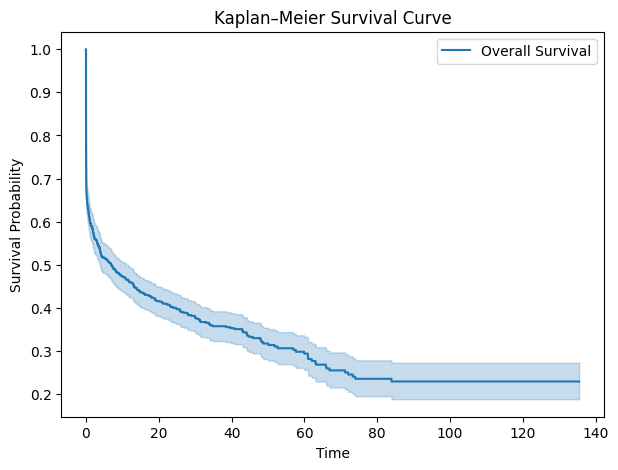

In [189]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

plt.figure(figsize=(7,5))
kmf.fit(
    durations=surv_train['duration'],
    event_observed=surv_train['event'],
    label="Overall Survival"
)
kmf.plot_survival_function()
plt.title("Kaplan–Meier Survival Curve")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()


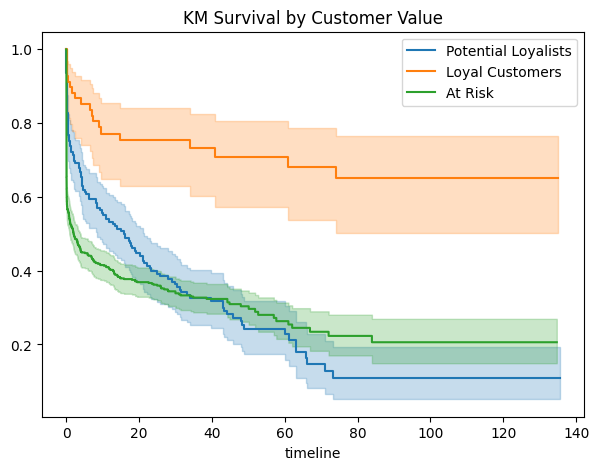

In [190]:

plt.figure(figsize=(7,5))
for label in ['Potential Loyalists', 'Loyal Customers', 'At Risk']:
    kmf.fit(
        surv_train.loc[surv_train['business_label']==label, 'duration'],
        surv_train.loc[surv_train['business_label']==label, 'event'],
        label=label
    )
    kmf.plot_survival_function()

plt.title("KM Survival by Customer Value")
plt.show()


#### CoxPHF

In [191]:
from lifelines import CoxPHFitter

cox_df = surv_train[['duration', 'event'] + surv_features].copy()

cox = CoxPHFitter(penalizer=0.1)
cox.fit(
    cox_df,
    duration_col='duration',
    event_col='event',
    show_progress=True
)

cox.print_summary()


Iteration 1: norm_delta = 3.30e-01, step_size = 0.9500, log_lik = -3334.19306, newton_decrement = 4.63e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.33e-01, step_size = 0.9500, log_lik = -3282.37648, newton_decrement = 8.21e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.71e-01, step_size = 0.9500, log_lik = -3272.27545, newton_decrement = 4.26e+00, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.11e-01, step_size = 0.9310, log_lik = -3267.24175, newton_decrement = 9.42e-01, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.52e-02, step_size = 0.9124, log_lik = -3266.24816, newton_decrement = 3.92e-02, seconds_since_start = 0.1
Iteration 6: norm_delta = 4.54e-04, step_size = 1.0000, log_lik = -3266.20849, newton_decrement = 1.24e-05, seconds_since_start = 0.1
Iteration 7: norm_delta = 1.32e-07, step_size = 1.0000, log_lik = -3266.20847, newton_decrement = 1.07e-12, seconds_since_start = 0.1
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 824 total observations, 282 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 824
number of events observed = 542
   partial log-likelihood = -3266.21
         time fit was run = 2025-12-22 11:56:56 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
total_events               0.01      1.01      0.10           -0.18            0.21                0.83                1.23
tenure_days               -0.30      0.74      0.05           -0.41           -0.20                0.66                0.82
total_views                0.02      1.02      0.10           -0.17            0.21                0.84                1.23
total_addtocarts           0.00      1.00      0.09           -0.17            0.18                0.84                1.20
total_tx                  -0.04      0.96      0.10           -0.22            0.15                0.80                1.16
distinct_items            -0.01      0.99      0.10           -0.20            0.18                0.82                1.20
view_items                -0.01      0.99      0.10           -0.20            0.19                0.82                1.20
addtocart_items           -0.06      0.94      0.10           -0.25            0.13                0.78                1.14
tx_items                  -0.09      0.91      0.10           -0.28            0.09                0.75                1.10
prop_addtocart            -0.07      0.94      0.05           -0.16            0.02                0.85                1.03
prop_tx                    0.04      1.05      0.05           -0.05            0.14                0.95                1.15
events_7d                 -0.15      0.86      0.10           -0.35            0.06                0.71                1.06
events_14d                -0.21      0.81      0.10           -0.41           -0.00                0.66                1.00
events_30d                -0.32      0.73      0.10           -0.51           -0.12                0.60                0.89
active_days               -0.07      0.93      0.07           -0.21            0.07                0.81                1.07
events_per_active_day      0.10      1.11      0.05           -0.00            0.20                1.00                1.23
predicted_avg_transaction -0.03      0.97      0.05           -0.13            0.06                0.88                1.06
predicted_clv_bg_gamma    -0.11      0.89      0.10           -0.32            0.09                0.73                1.09
predicted_purchases_bgf   -0.10      0.91      0.11           -0.31            0.11                0.74                1.12

                           cmp to     z      p  -log2(p)
covariate                                               
total_events                 0.00  0.14   0.89      0.17
tenure_days                  0.00 -5.72 <0.005     26.50
total_views                  0.00  0.20   0.84      0.25
total_addtocarts             0.00  0.05   0.96      0.06
total_tx                     0.00 -0.38   0.70      0.51
distinct_items               0.00 -0.12   0.90      0.14
view_items                   0.00 -0.06   0.95      0.07
addtocart_items              0.00 -0.59   0.55      0.86
tx_items                     0.00 -0.99   0.32      1.64
prop_addtocart               0.00 -1.43   0.15      2.71
prop_tx                      0.00  0.95   0.34      1.55
events_7d                    0.00 -1.42   0.15      2.69
events_14d                   0.00 -1.99   0.05      4.41
events_30d                   0.00 -3.15 <0.005      9.25
active_days                  0.00 -1.03   0.30      1.73



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 824 total observations, 282 right-censored observations>
         test_name = proportional_hazard_test

---
                                test_statistic    p  -log2(p)
active_days               km              4.38 0.04      4.78
                          rank            4.25 0.04      4.67
addtocart_items           km              0.25 0.62      0.69
                          rank            0.25 0.62      0.69
distinct_items            km              0.00 0.97      0.05
                          rank            0.00 0.98      0.02
events_14d                km              0.05 0.83      0.27
                          rank            0.05 0.83      0.27
events_30d                km              1.06 0.30      1.72
                          rank            1.03 0.31      1.69
events_7d                 km              0.01 0.93      0.11
                          rank            0.01 0.94      0.09
events_per_active_day     km              3.72 0.05      4.21
                          rank            4.66 0.03      5.02
predicted_avg_transaction km              0.03 0.86      0.22
                          rank            0.00 0.99      0.02
predicted_clv_bg_gamma    km              0.16 0.69      0.54
                          rank            0.15 0.70      0.52
predicted_purchases_bgf   km              0.19 0.67      0.59
                          rank            0.17 0.68      0.56
prop_addtocart            km              3.71 0.05      4.21
                          rank            3.56 0.06      4.08
prop_tx                   km              0.84 0.36      1.47
                          rank            0.95 0.33      1.60
tenure_days               km              3.80 0.05      4.29
                          rank            3.90 0.05      4.37
total_addtocarts          km              0.39 0.53      0.91
                          rank            0.31 0.58      0.80
total_events              km              0.01 0.93      0.10
                          rank            0.00 0.96      0.06
total_tx                  km              0.12 0.73      0.45
                          rank            0.15 0.70      0.52
total_views               km              0.00 0.96      0.05
                          rank            0.00 0.99      0.01
tx_items                  km              0.31 0.58      0.79
                          rank            0.36 0.55      0.86
view_items                km              0.00 0.95      0.08
                          rank            0.00 0.97      0.05



1. Variable 'tenure_days' failed the non-proportional test: p-value is 0.0483.

   Advice 1: the functional form of the variable 'tenure_days' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'tenure_days' using pd.cut, and then specify it in
`strata=['tenure_days', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping l

[[<Axes: xlabel='rank-transformed time\n(p=0.9577)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9311)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0483)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0511)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9904)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9628)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5760)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5309)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6954)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7302)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9835)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9658)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9669)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9471)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6198)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6184)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5510)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5768)'>],
 [<Axes: xlabel='rank-transformed tim

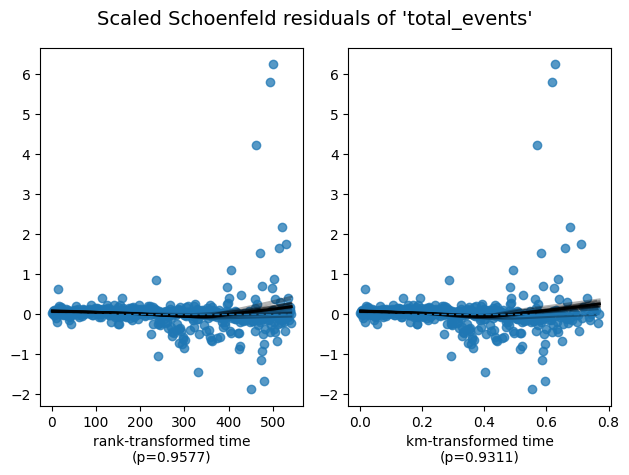

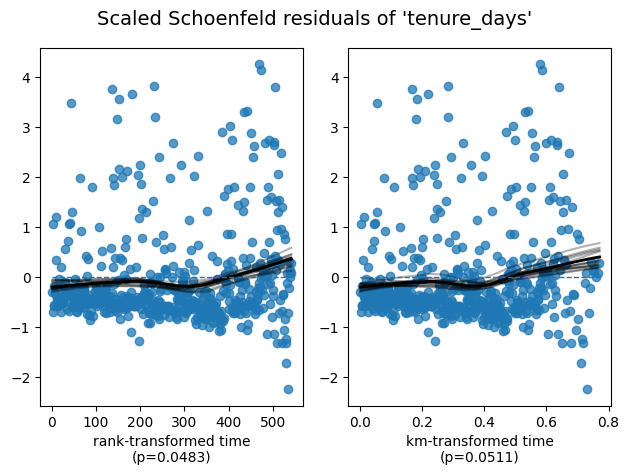

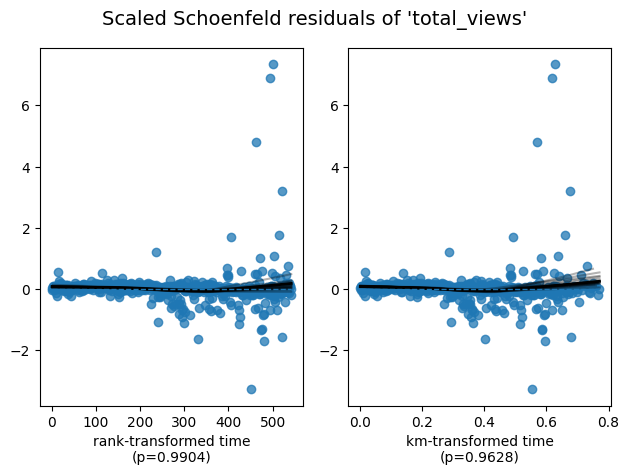

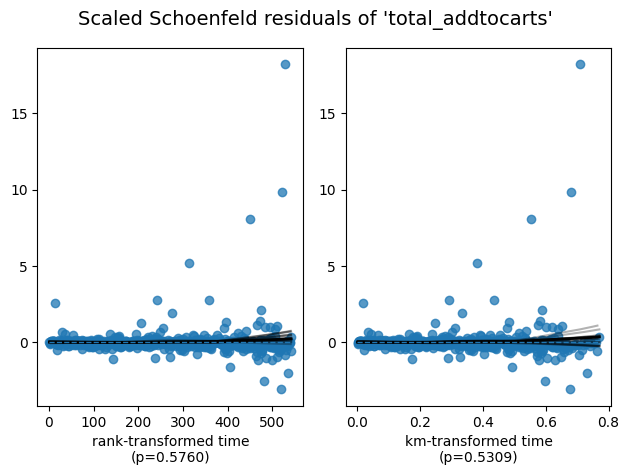

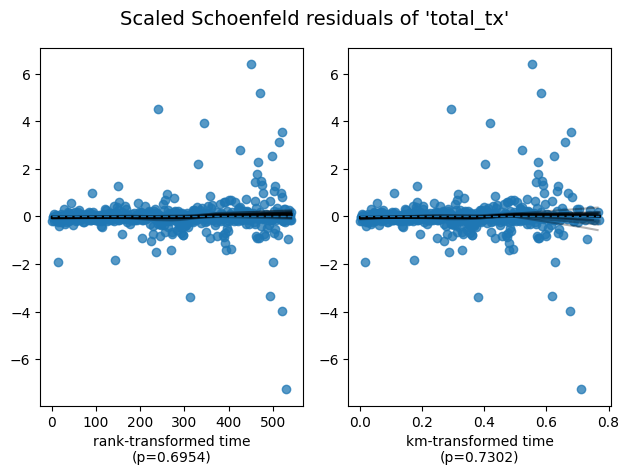

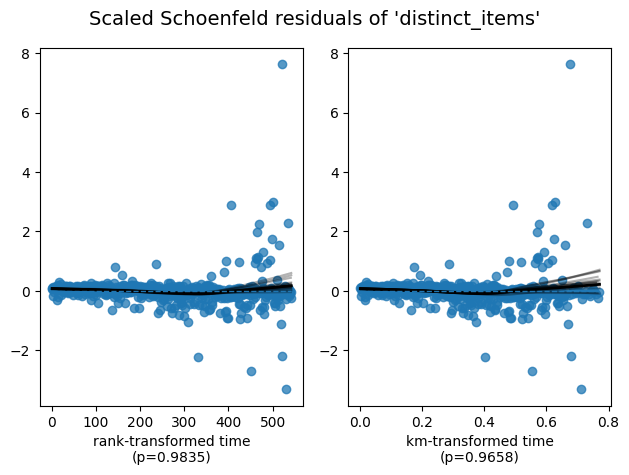

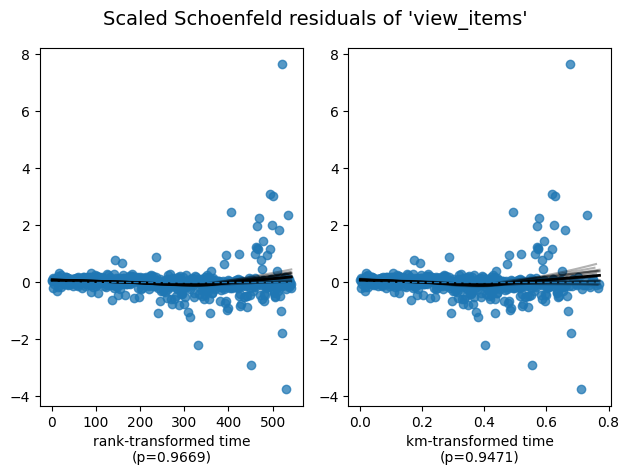

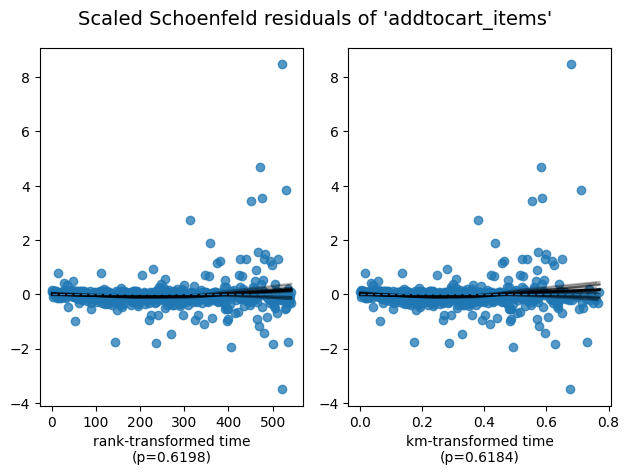

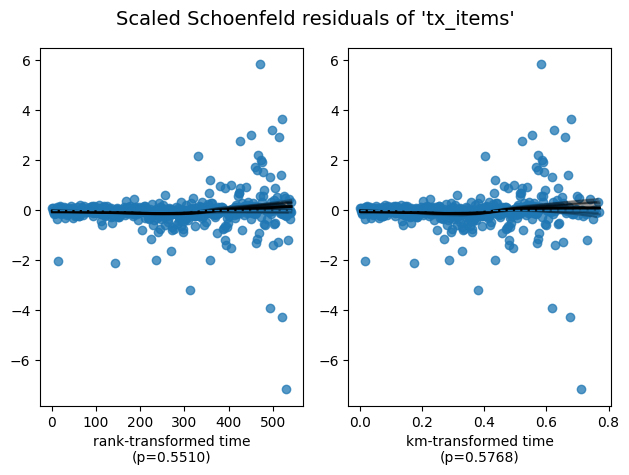

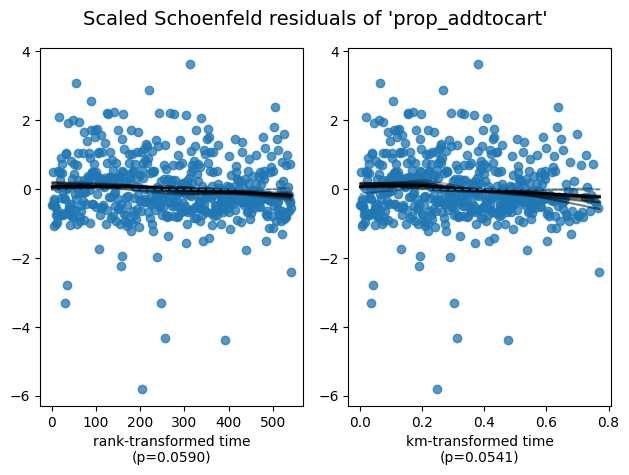

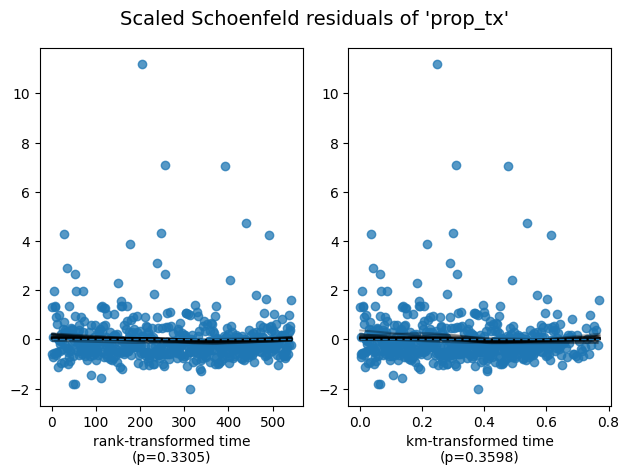

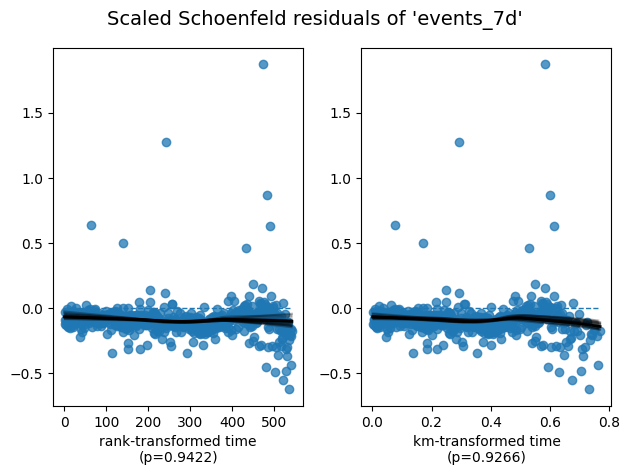

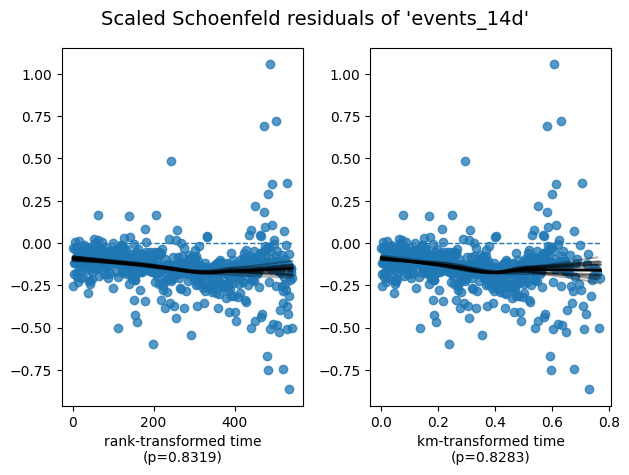

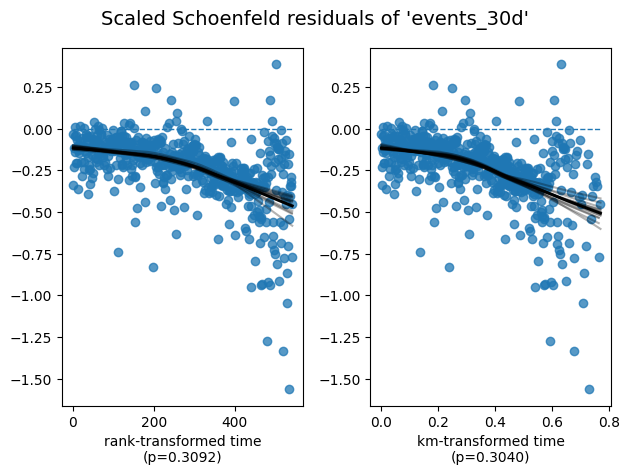

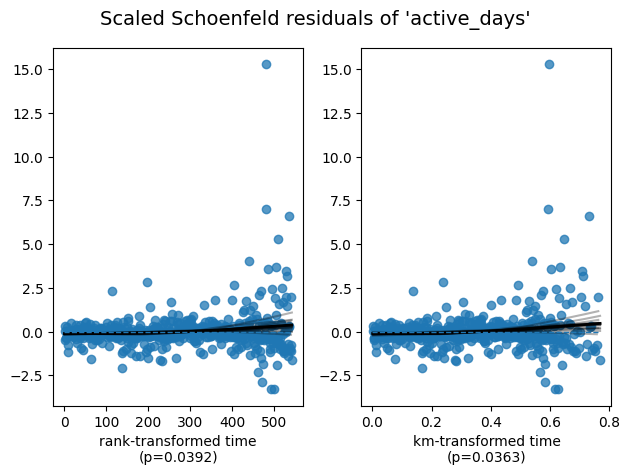

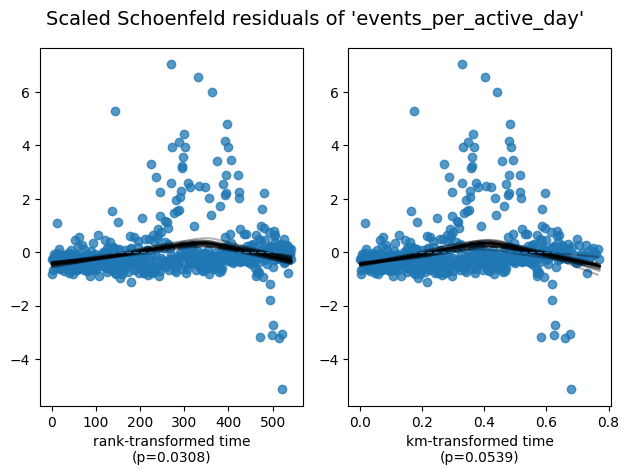

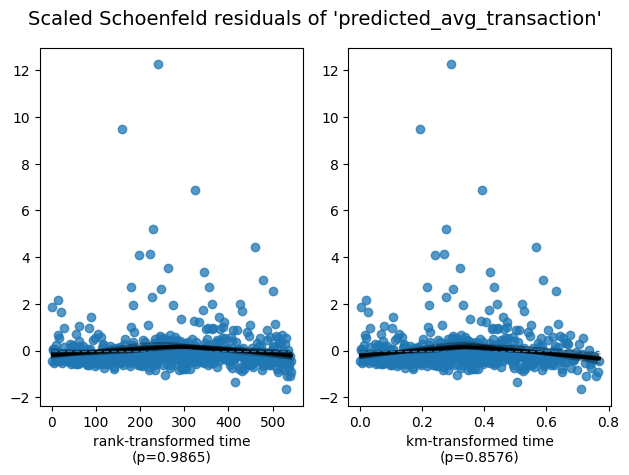

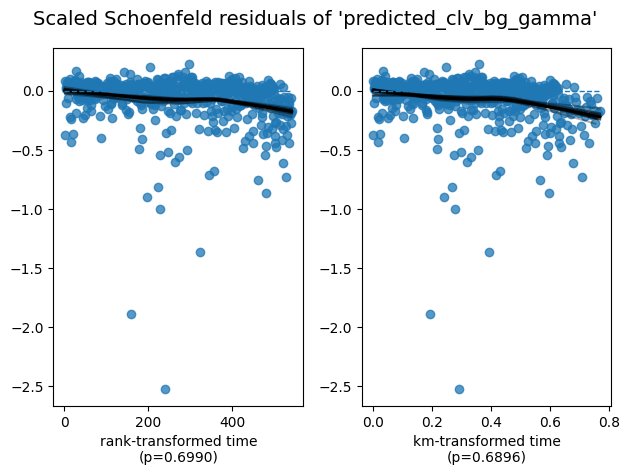

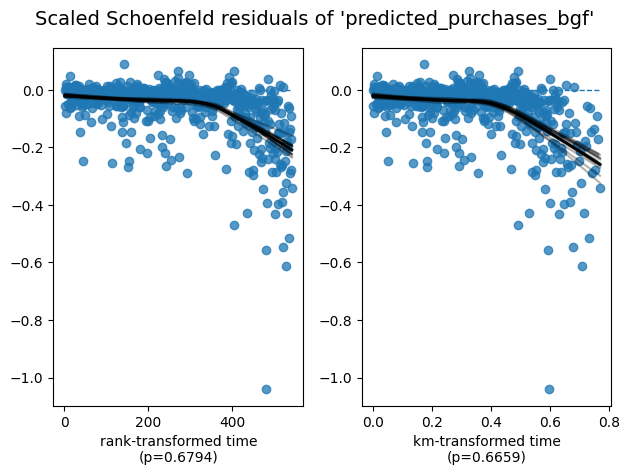

In [192]:
cox.check_assumptions(
    cox_df,
    p_value_threshold=0.05,
    show_plots=True
)


In [193]:
cox_pred = cox.predict_partial_hazard(
    surv_test[surv_features]
)

cox_cindex = concordance_index(
    surv_test['duration'],
    -cox_pred,
    surv_test['event']
)

print(f"Cox C-index: {cox_cindex:.4f}")


Cox C-index: 0.6959


<Figure size 700x500 with 0 Axes>

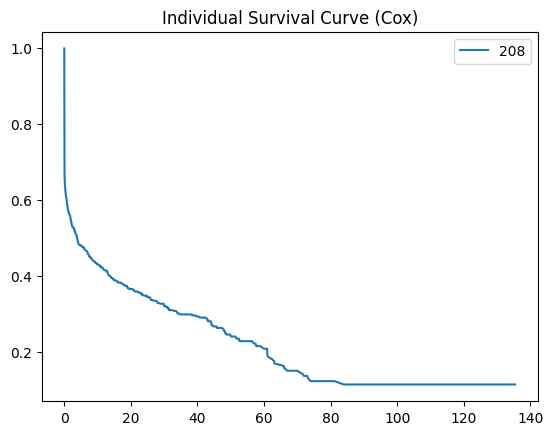

In [194]:
sample = surv_test.iloc[[0]][surv_features]

plt.figure(figsize=(7,5))
cox.predict_survival_function(sample).plot()
plt.title("Individual Survival Curve (Cox)")
plt.show()


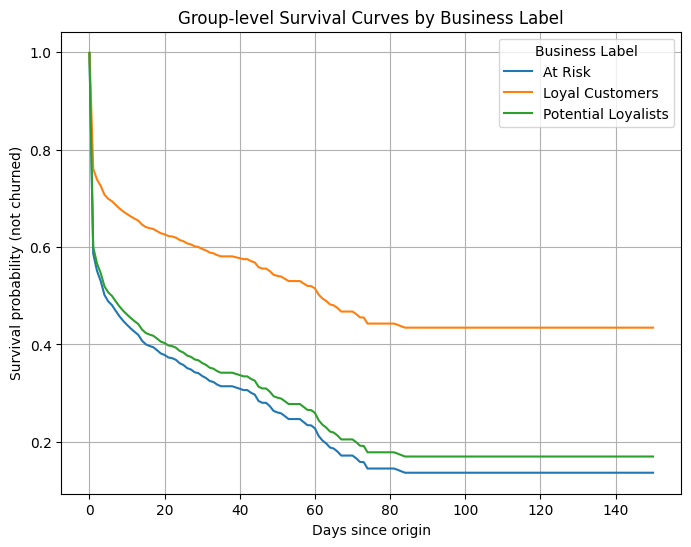

In [195]:
time_grid = np.linspace(0, 150, 151)   # days
sf_all = cox.predict_survival_function(
    surv_test[surv_features],
    times=time_grid
)
sf_all_T = sf_all.T.copy()   # users × time
sf_all_T["business_label"] = surv_test["business_label"].values
group_survival = (
    sf_all_T
    .groupby("business_label")
    .mean()
)
plt.figure(figsize=(8,6))

for label in group_survival.index:
    plt.plot(
        time_grid,
        group_survival.loc[label].values,
        label=f"{label}"
    )

plt.xlabel("Days since origin")
plt.ylabel("Survival probability (not churned)")
plt.title("Group-level Survival Curves by Business Label")
plt.legend(title="Business Label")
plt.grid(True)
plt.show()


In [196]:
cox_summary = cox.summary.copy()

cox_summary['HR'] = np.exp(cox_summary['coef'])
cox_summary['HR_lower'] = np.exp(cox_summary['coef lower 95%'])
cox_summary['HR_upper'] = np.exp(cox_summary['coef upper 95%'])

business_table = cox_summary[
    ['HR', 'HR_lower', 'HR_upper', 'p']
].sort_values('HR', ascending=False)

print("\n=== Cox Hazard Ratios (Business View) ===")
print(business_table)



=== Cox Hazard Ratios (Business View) ===
                                 HR  HR_lower  HR_upper             p
covariate                                                            
events_per_active_day      1.106418  0.997888  1.226752  5.487917e-02
prop_tx                    1.045622  0.953848  1.146225  3.411873e-01
total_views                1.019258  0.843242  1.232016  8.436611e-01
total_events               1.014310  0.834808  1.232410  8.862978e-01
total_addtocarts           1.004676  0.840588  1.200796  9.591032e-01
view_items                 0.993957  0.821081  1.203231  9.504235e-01
distinct_items             0.988361  0.815908  1.197263  9.047444e-01
predicted_avg_transaction  0.966075  0.879897  1.060694  4.690843e-01
total_tx                   0.964024  0.799540  1.162346  7.010875e-01
addtocart_items            0.943752  0.779696  1.142326  5.523819e-01
prop_addtocart             0.935837  0.854423  1.025007  1.532737e-01
active_days                0.929422  0.809097  

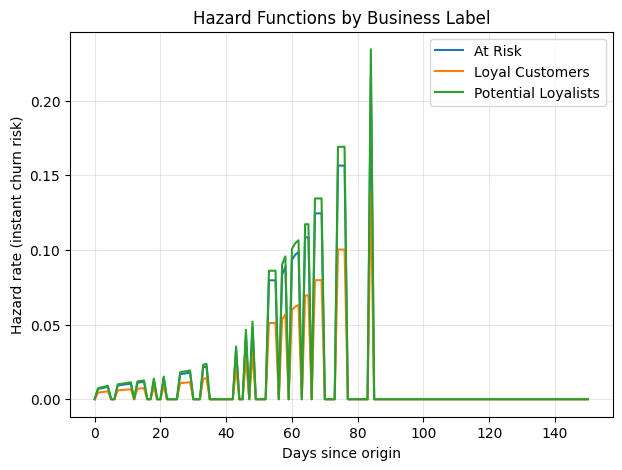

In [197]:
times = np.linspace(0, 150, 151)   # days

# baseline hazard (step function)
h0 = (
    cox.baseline_hazard_
       .reindex(times, method="ffill")
       .fillna(0)
)

plt.figure(figsize=(7,5))

for label, g in surv_test.groupby("business_label"):
    # exp(xβ)
    risk = np.exp(
        cox.predict_partial_hazard(g[surv_features]).values
    )
    # group-average hazard
    hazard = h0.values.flatten() * risk.mean()
    plt.plot(times, hazard, label=label)

plt.xlabel("Days since origin")
plt.ylabel("Hazard rate (instant churn risk)")
plt.title("Hazard Functions by Business Label")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [198]:
print("\n=== Feature-Level Business Interpretation ===")

for feature, row in business_table.iterrows():
    hr = row['HR']
    p = row['p']

    if p > 0.05:
        print(f"{feature}: No statistically significant effect (p={p:.3f})")
        continue

    if hr > 1:
        print(
            f"{feature}: +{(hr-1)*100:.1f}% higher churn risk "
            f"(HR={hr:.2f}, p={p:.3f})"
        )
    else:
        print(
            f"{feature}: −{(1-hr)*100:.1f}% lower churn risk "
            f"(HR={hr:.2f}, p={p:.3f})"
        )



=== Feature-Level Business Interpretation ===
events_per_active_day: No statistically significant effect (p=0.055)
prop_tx: No statistically significant effect (p=0.341)
total_views: No statistically significant effect (p=0.844)
total_events: No statistically significant effect (p=0.886)
total_addtocarts: No statistically significant effect (p=0.959)
view_items: No statistically significant effect (p=0.950)
distinct_items: No statistically significant effect (p=0.905)
predicted_avg_transaction: No statistically significant effect (p=0.469)
total_tx: No statistically significant effect (p=0.701)
addtocart_items: No statistically significant effect (p=0.552)
prop_addtocart: No statistically significant effect (p=0.153)
active_days: No statistically significant effect (p=0.301)
tx_items: No statistically significant effect (p=0.321)
predicted_purchases_bgf: No statistically significant effect (p=0.359)
predicted_clv_bg_gamma: No statistically significant effect (p=0.272)
events_7d: No st

In [199]:
impact_rank = business_table.copy()
impact_rank['impact_strength'] = np.abs(np.log(impact_rank['HR']))
impact_rank = impact_rank.sort_values('impact_strength', ascending=False)

print("\n=== Most Influential Business Drivers ===")
print(impact_rank[['HR', 'p']].head(10))



=== Most Influential Business Drivers ===
                               HR             p
covariate                                      
events_30d               0.728105  1.642953e-03
tenure_days              0.737538  1.050402e-08
events_14d               0.813380  4.694694e-02
events_7d                0.863364  1.545893e-01
predicted_clv_bg_gamma   0.892761  2.715328e-01
events_per_active_day    1.106418  5.487917e-02
predicted_purchases_bgf  0.906872  3.593451e-01
tx_items                 0.909856  3.209900e-01
active_days              0.929422  3.008045e-01
prop_addtocart           0.935837  1.532737e-01


In [200]:
surv_test['cox_risk_score'] = cox.predict_partial_hazard(
    surv_test[surv_features]
)

print("\nRisk score summary:")
print(surv_test['cox_risk_score'].describe())



Risk score summary:
count    207.000000
mean       1.173820
std        0.417128
min        0.001832
25%        0.924166
50%        1.283990
75%        1.413578
max        2.734226
Name: cox_risk_score, dtype: float64


In [201]:
surv_test['risk_segment'] = pd.qcut(
    surv_test['cox_risk_score'],
    q=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("\n=== Risk Segment Distribution ===")
print(surv_test['risk_segment'].value_counts())



=== Risk Segment Distribution ===
risk_segment
Low          52
Medium       52
Very High    52
High         51
Name: count, dtype: int64


#### Random Survival Forest

In [202]:
from sksurv.util import Surv

X_train = surv_train[surv_features]
X_test  = surv_test[surv_features]

y_train = Surv.from_arrays(
    event=surv_train['event'].astype(bool),
    time=surv_train['duration']
)

y_test = Surv.from_arrays(
    event=surv_test['event'].astype(bool),
    time=surv_test['duration']
)


In [203]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    random_state=42
)

rsf.fit(X_train, y_train)


,n_estimators,300
,max_depth,None
,min_samples_split,10
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,bootstrap,True
,oob_score,False
,n_jobs,None
,random_state,42


In [204]:
rsf_pred = rsf.predict(X_test)

rsf_cindex = concordance_index(
    surv_test['duration'],
    -rsf_pred,
    surv_test['event']
)

print(f"RSF C-index: {rsf_cindex:.4f}")


RSF C-index: 0.8951


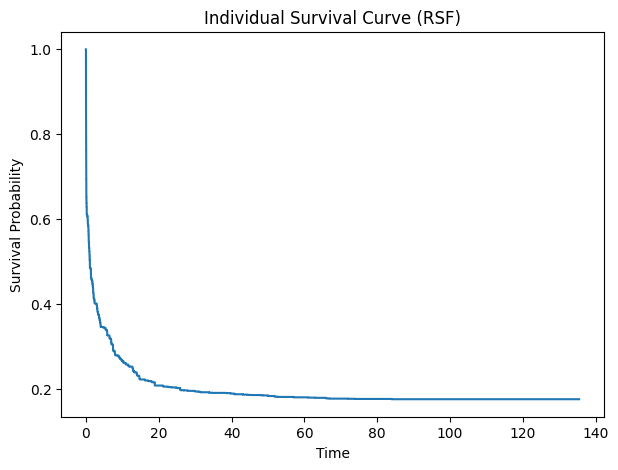

In [205]:
sample = X_test.iloc[[0]]

surv_fn = rsf.predict_survival_function(sample, return_array=False)

# extract the step function
sf = surv_fn[0]

plt.figure(figsize=(7,5))
plt.step(sf.x, sf.y, where="post")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Individual Survival Curve (RSF)")
plt.show()


In [206]:
def score_fn(model, X, y):
    pred = model.predict(X)
    ci = concordance_index_censored(y["event"], y["time"], pred)[0]
    return ci

result = permutation_importance(
    rsf,
    surv_train[surv_features],
    y_train,
    n_repeats=5,
    scoring=score_fn,
    random_state=42
)

importance = pd.Series(
    result.importances_mean,
    index=surv_features
).sort_values(ascending=False)

print(importance)


predicted_clv_bg_gamma       0.092674
predicted_purchases_bgf      0.091171
events_30d                   0.039261
total_tx                     0.011902
tx_items                     0.007026
tenure_days                  0.006034
addtocart_items              0.005295
active_days                  0.003371
total_addtocarts             0.002811
events_per_active_day        0.002147
predicted_avg_transaction    0.001920
events_14d                   0.001883
total_events                 0.001789
view_items                   0.001314
distinct_items               0.001310
total_views                  0.000811
prop_addtocart               0.000641
prop_tx                      0.000296
events_7d                    0.000014
dtype: float64


In [207]:
customer = X_test.iloc[[0]]
surv_curve = rsf.predict_survival_function(customer, return_array=False)[0]

times = rsf.unique_times_

business_df = pd.DataFrame({
    'time': times,
    'survival_prob': surv_curve.y
})
expected_lifetime = np.trapz(
    business_df['survival_prob'],
    business_df['time']
)

print(f"\nExpected remaining lifetime: {expected_lifetime:.1f}")





Expected remaining lifetime: 27.0


C:\Users\Acer\AppData\Local\Temp\ipykernel_10424\1222959776.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expected_lifetime = np.trapz(


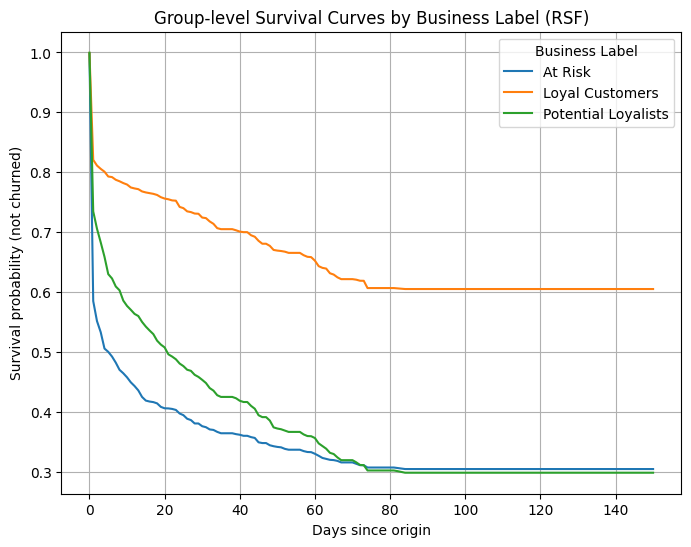

In [208]:
time_grid = np.linspace(0, 150, 151)   # days
surv_fns = rsf.predict_survival_function(
    X_test[surv_features],
    return_array=False
)
sf_array = np.zeros((len(surv_fns), len(time_grid)))

for i, fn in enumerate(surv_fns):
    sf_array[i, :] = np.interp(time_grid, fn.x, fn.y)
sf_df = pd.DataFrame(sf_array, columns=time_grid)
sf_df["business_label"] = surv_test["business_label"].values
group_survival_rsf = (
    sf_df
    .groupby("business_label")
    .mean()
)
plt.figure(figsize=(8,6))
for label in group_survival_rsf.index:
    plt.plot(
        time_grid,
        group_survival_rsf.loc[label].values,
        label=f"{label}"
    )
plt.xlabel("Days since origin")
plt.ylabel("Survival probability (not churned)")
plt.title("Group-level Survival Curves by Business Label (RSF)")
plt.legend(title="Business Label")
plt.grid(True)
plt.show()


In [209]:
print("\n=== Model Comparison Summary ===")
print(f"Cox C-index: {cox_cindex:.3f}")
print(f"RSF C-index: {rsf_cindex:.3f}")



=== Model Comparison Summary ===
Cox C-index: 0.696
RSF C-index: 0.895


### Train to entire dataset

In [210]:
surv_train = user_data.copy()
surv_features = features.copy()
surv_train['duration'] = surv_train['time_to_event']
surv_train['event'] = surv_train['churned']
surv_train[surv_features] = scaler.fit_transform(
    surv_train[surv_features].fillna(0)
)
y = Surv.from_arrays(
    event=surv_train["event"].astype(bool),
    time=surv_train["duration"]
)
X = surv_train[surv_features]
rsf = RandomSurvivalForest(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rsf.fit(X, y)

print("RSF training done!")

RSF training done!


In [211]:
# target day
day = 30
surv_fns = rsf.predict_survival_function(
    X,
    return_array=False
)
survival_30 = []
for fn in surv_fns:
    survival_30.append(
        np.interp(day, fn.x, fn.y)
    )
survival_30 = pd.Series(
    survival_30,
    index=surv_train.index,
    name="survival_30"
)
user_data = user_data.join(survival_30)

In [212]:
user_data

,Unnamed: 0,visitorid,total_events,first_event,last_event,recency_days,tenure_days,total_views,total_addtocarts,total_tx,...,active_days,events_per_active_day,business_label,predicted_avg_transaction,predicted_clv_bg_gamma,predicted_purchases_bgf,origin,time_to_event,churned,survival_30
0,3926,3926,13,2015-06-02 19:44:15.832,2015-08-18 20:41:30.407,30,78,8,3,3,...,3,4.333333,At Risk,122745.966383,1310.135500,1.067355e-02,2015-06-02 20:01:56.963,14.193558,1,0.215266
1,4537,4537,10,2015-05-14 01:23:42.959,2015-09-07 01:26:13.013,11,117,5,3,2,...,3,3.333333,At Risk,134100.331110,1536.451779,1.145748e-02,2015-09-06 18:08:08.780,11.369201,0,0.716486
2,5042,5042,13,2015-07-12 16:23:12.305,2015-07-12 17:46:39.453,67,1,7,3,3,...,1,13.000000,Potential Loyalists,104825.387057,0.009852,9.398102e-08,2015-07-12 16:48:47.267,0.021983,1,0.320050
3,6699,6699,104,2015-05-07 21:30:27.547,2015-05-08 03:01:06.009,132,1,92,8,4,...,2,52.000000,Loyal Customers,96356.189166,0.000481,4.991540e-09,2015-05-07 21:54:11.023,0.211585,1,0.045010
4,8043,8043,10,2015-07-21 23:46:29.406,2015-08-20 21:48:51.263,28,30,6,2,2,...,3,3.333333,At Risk,117981.475519,2708.549366,2.295741e-02,2015-08-17 20:17:10.774,31.279595,0,0.836325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,1398505,1398505,15,2015-06-27 05:52:13.778,2015-07-22 01:48:20.868,58,25,11,2,2,...,4,3.750000,At Risk,114513.649889,0.175914,1.536186e-06,2015-06-27 06:01:50.762,0.001642,1,0.015226
1027,1398811,1398811,77,2015-06-02 07:39:34.032,2015-09-08 02:37:21.023,10,98,72,3,2,...,16,4.812500,At Risk,112191.714468,4714.496391,4.202179e-02,2015-06-06 02:03:03.373,44.213079,1,0.621567
1028,1402220,1402220,13,2015-05-14 03:53:30.291,2015-05-14 04:13:08.260,126,1,8,3,3,...,1,13.000000,At Risk,111287.064304,0.099228,8.916374e-07,2015-05-14 04:07:09.841,0.004148,1,0.034159
1029,1403769,1403769,469,2015-05-05 13:56:50.353,2015-09-15 22:27:21.631,2,134,444,18,7,...,79,5.936709,Loyal Customers,122300.205024,58906.610692,4.816559e-01,2015-05-12 18:47:42.112,128.341732,0,0.977727


In [213]:
user_data.to_csv(USER_FEATS_FILE, index = False)